# Chemical Space Networks Based on Maximum Common Substructure


## 1. Import RDKit, Networkx, and other libraries

In [1]:
# RDKit stuff
from rdkit import Chem
from rdkit import rdBase
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import rdFMCS
from rdkit import DataStructs

# numpy
import numpy as np

# pandas
import pandas as pd

# networkx
import networkx as nx

# matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# Print versions of libraries used
print('RDKit version: ',rdBase.rdkitVersion)
print('Numpy version:', np.__version__)
print('Pandas version:', pd.__version__)
print('Networkx version',nx.__version__)
print('MatplotLib version:', mpl.__version__)

RDKit version:  2023.03.1
Numpy version: 1.26.4
Pandas version: 2.1.4
Networkx version 2.8.8
MatplotLib version: 3.8.0


# 2. Load Data

In [3]:
# load the subsets data
import pickle
with open('../Data/subsets_cata.pickle', 'rb') as infile:
    subsets = pickle.load(infile)

In [4]:
list(subsets.values())[0:5]

[{'smi1': 'CC(C)(C)c1ccccc1',
  'smi2': 'CC(C)CCc1cccc(CCC(C)C)c1',
  'mol1': <rdkit.Chem.rdchem.Mol at 0x1659a6cf0>,
  'mol2': <rdkit.Chem.rdchem.Mol at 0x1659a6d90>,
  'tan_similarity': 0.382,
  'tan_mcs': 0.4444444444444444},
 {'smi1': 'CC(C)(C)c1ccccc1',
  'smi2': 'CC3(C)c1ccccc1c2ccccc23',
  'mol1': <rdkit.Chem.rdchem.Mol at 0x1659a6e80>,
  'mol2': <rdkit.Chem.rdchem.Mol at 0x1659a6f20>,
  'tan_similarity': 0.186,
  'tan_mcs': 0.5882352941176471},
 {'smi1': 'CC(C)(C)c1ccccc1',
  'smi2': 'CCCCCCc1cccc(CCCCCC)c1',
  'mol1': <rdkit.Chem.rdchem.Mol at 0x1659a7010>,
  'mol2': <rdkit.Chem.rdchem.Mol at 0x1659a70b0>,
  'tan_similarity': 0.361,
  'tan_mcs': 0.4},
 {'smi1': 'CC(C)(C)c1ccccc1',
  'smi2': 'CCCc1cccc(CCC)c1',
  'mol1': <rdkit.Chem.rdchem.Mol at 0x1659a71a0>,
  'mol2': <rdkit.Chem.rdchem.Mol at 0x1659a5260>,
  'tan_similarity': 0.431,
  'tan_mcs': 0.5714285714285714},
 {'smi1': 'CC(C)(C)c1ccccc1',
  'smi2': 'CCc1cccc(CC)c1',
  'mol1': <rdkit.Chem.rdchem.Mol at 0x1659a7290>,
  

In [5]:
# load the node data
with open('../Data/node_data_cata.pickle', 'rb') as infile:
    node_data = pickle.load(infile)

In [6]:
list(node_data.keys())[0:5]

['CC(C)(C)c1ccccc1',
 'CC(C)CCc1cccc(CCC(C)C)c1',
 'CC3(C)c1ccccc1c2ccccc23',
 'CCCCCCc1cccc(CCCCCC)c1',
 'CCCc1cccc(CCC)c1']

In [7]:
list(node_data.values())[0:5]

[0.899319951570055,
 0.9145934411833792,
 0.9340876369031593,
 0.9231929042101648,
 0.9277499331002746]

# 3. Create CSN based on Maximum Common Substructure-based Similarity

In [8]:
# total number of possible edges
len(subsets)

300

In [78]:
subsets_filtered_mcs = {}
subsets_filtered_mcs = {key: value for key, value in subsets.items() if value['tan_mcs'] >= 0.65}
len(subsets_filtered_mcs) # equals number of edges

77

In [79]:
# Edge density (number of edges / number of total edges)
# Defined in: Zhang, B. et al.J Comput Aided Mol Des 2015, 29 (10), 937–950. 
# https://doi.org/10.1007/s10822-015-9872-1.

edge_density_mcs = round((len(subsets_filtered_mcs) / len(subsets)),3)
edge_density_mcs

0.257

In [80]:
# create a list of SMILES that will be nodes from the edges
smi1_filtered_mcs = []
smi2_filtered_mcs = []
for key,value in subsets_filtered_mcs.items():
    smi1_filtered_mcs.append(value['smi1'])
    smi2_filtered_mcs.append(value['smi2'])
    
# combine the 2 lists
smi12_filtered_mcs = smi1_filtered_mcs + smi2_filtered_mcs

# get unique
smi12_filtered_set = set(smi12_filtered_mcs)
len(smi12_filtered_set) # of nodes (smiles) in network

22

In [81]:
len(node_data) # original

25

In [82]:
smis = []
for key,value in node_data.items():
    smis.append(key)

In [83]:
# print list of nodes that are not in the filtered list
nodes_to_remove = set(smis) - smi12_filtered_set
nodes_to_remove

{'FC(F)(F)C(F)(F)C(F)(F)c1cccc(C(F)(F)C(F)(F)C(F)(F)F)c1',
 'FC(F)(F)C(F)(c1cccc(C(F)(C(F)(F)F)C(F)(F)F)c1)C(F)(F)F',
 'FC(F)(F)c1cccc(C(F)(F)F)c1'}

In [84]:
# finally, we can remove these from the node data as follows:
# this removes nodes from the graph with no edges
node_data_filtered_mcs = {node: node_data[node] for node in list(smi12_filtered_set)}
len(node_data_filtered_mcs)

22

## Plot MCS Similarity-based CSN as circle nodes

In [85]:
# Create a graph and add edges
G1 = nx.Graph()
for key, value in subsets_filtered_mcs.items():
    G1.add_edge(value['smi1'], value['smi2'], weight=value['tan_mcs'])

In [86]:
# Add attributes to nodes
for key,value in node_data_filtered_mcs.items():
    G1.add_node(key, pKi=round(value*100))

In [87]:
# Get number of seperate connected components
nx.number_connected_components(G1)

2

## Plot MCS Similarity-based CSN with 2D Structure Depictions as Nodes

In [88]:
# png function to view molecules
import io
from PIL import Image
def show_png(data):
    bio = io.BytesIO(data)
    img = Image.open(bio)
    return img

In [89]:
# define a function that highlights the molecule with the colors
# adjusted alpha values to make transparent
def highlight_mol(smi,label,color):
    
    mol = Chem.MolFromSmiles(smi)
    
    if color == 'darkred':
        rgba = (0.55, 0.0, 0.0, 0.3)       
    elif color == 'red':
        rgba = (1.0, 0.0, 0.0, 0.2)    
    elif color == 'orange':
        rgba = (1.0, 0.65, 0.0, 0.2)        
    elif color == 'yellow':
        rgba = (1.0, 1.0, 0.0, 0.4)        
    elif color == 'green':
        rgba = (0.0, 0.50, 0.0, 0.15)        
    elif color == 'lightblue':
        rgba = (0.68, 0.85, 0.90, 0.5)   
    elif color == 'blue':
        rgba = (0.0, 0.0, 1.0, 0.1)    
    else: # no color
        rgba = (1,1,1,1) 
             
    atoms = []
    for a in mol.GetAtoms():
        atoms.append(a.GetIdx())
    
    bonds = []
    for bond in mol.GetBonds():
        aid1 = atoms[bond.GetBeginAtomIdx()]
        aid2 = atoms[bond.GetEndAtomIdx()]
        bonds.append(mol.GetBondBetweenAtoms(aid1,aid2).GetIdx())

    drawer = rdMolDraw2D.MolDraw2DCairo(300,300)
    drawer.drawOptions().fillHighlights=True
    drawer.drawOptions().setHighlightColour((rgba))
    drawer.drawOptions().highlightBondWidthMultiplier=15
    drawer.drawOptions().legendFontSize=60
    drawer.drawOptions().clearBackground = False
    rdMolDraw2D.PrepareAndDrawMolecule(drawer, mol, legend=label,highlightAtoms=atoms, highlightBonds=bonds)
    
    mol_png = drawer.GetDrawingText()
    return mol_png

## Communities

In [90]:
# using the greedy_modularity_communities as an example
# There are many others, see the NetworkX docs

from networkx.algorithms.community import greedy_modularity_communities
communities = greedy_modularity_communities(G1, weight="weight") # added in similarity threshold as a weight

In [30]:
# add color to nodes by community group
colors_tab = ["orange",'green','blue']
community_color_map = []
for node in G1.nodes:
     for idx,community in enumerate(communities):
        if node in community:
            community_color_map.append(colors_tab[idx])

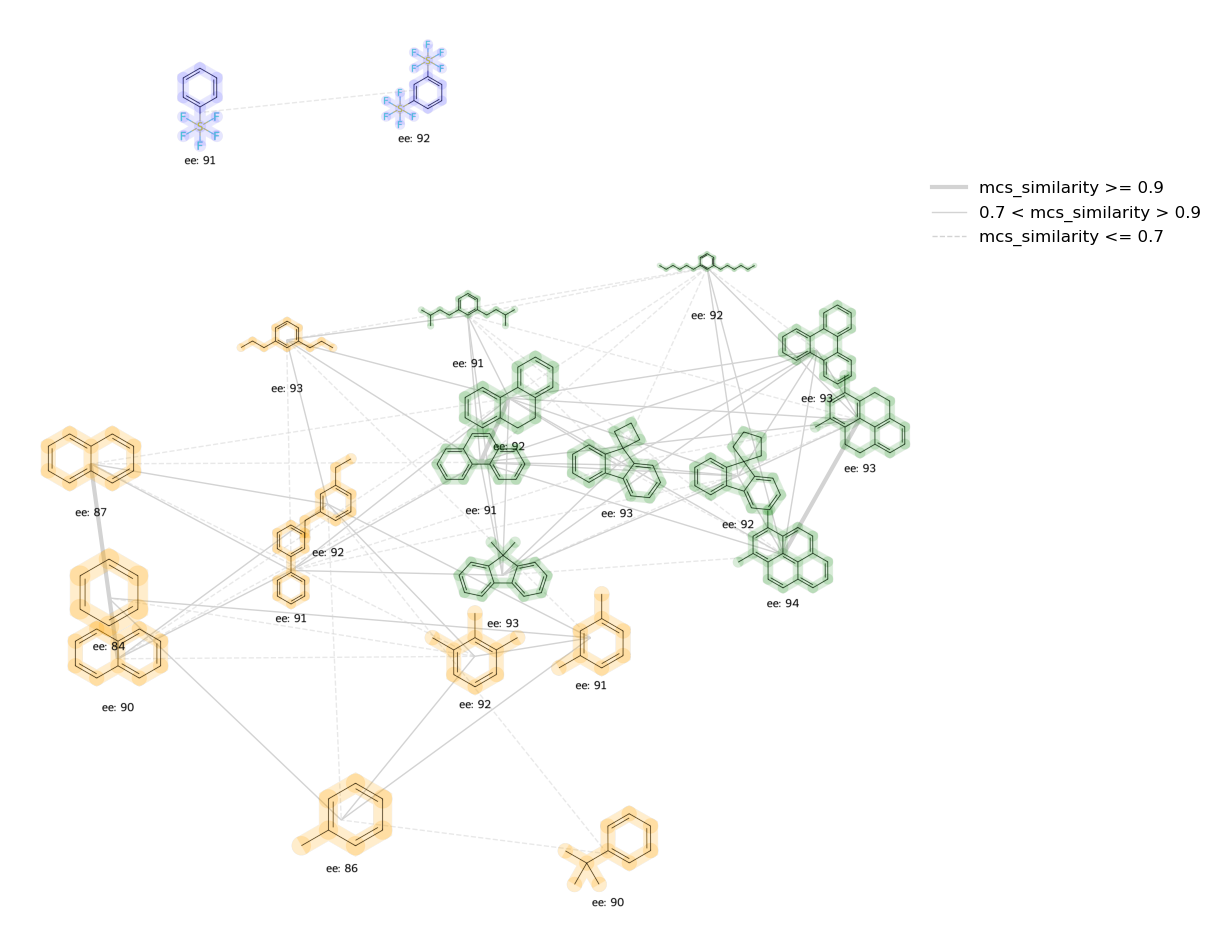

In [124]:
# Finally, add some legends
thick = [(u, v) for (u, v, d) in G1.edges(data=True) if d["weight"] >= 0.9]
medium = [(u, v) for (u, v, d) in G1.edges(data=True) if 0.7 < d["weight"] < 0.9]
thin = [(u, v) for (u, v, d) in G1.edges(data=True) if d["weight"] <= 0.7]

pos = nx.spring_layout(G1,  k=1.25, seed=10)
fig, ax = plt.subplots(figsize=(12, 12))
nx.draw_networkx_edges(G1, pos=pos, ax=ax, edgelist=thick, width=3, edge_color="lightgrey")
nx.draw_networkx_edges(G1, pos=pos, ax=ax, edgelist=medium, width=1, edge_color="lightgrey")
nx.draw_networkx_edges(G1, pos=pos, ax=ax, edgelist=thin, width=1, alpha=0.5, edge_color="lightgrey", style="dashed")
ax.axis('off')

# Transform from data coordinates (scaled between xlim and ylim) to display coordinates
tr_figure = ax.transData.transform
# Transform from display to figure coordinates
tr_axes = fig.transFigure.inverted().transform

# Select the size of the image (relative to the X axis)
struct_size = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.05
struct_center = struct_size / 2.0

# Add the respective image to each node

for smi,value in G1.nodes.items():

    for idx,community in enumerate(communities):
        if smi in community:
            #print(node,idx)
            highlight_color =colors_tab[idx]
    

    xf, yf = tr_figure(pos[smi])
    xa, ya = tr_axes((xf, yf))
    # get overlapped axes and plot
    a = plt.axes([xa - struct_center, ya - struct_center, struct_size, struct_size])
    a.imshow(show_png(highlight_mol(smi,"ee: "+str(value["pKi"]), highlight_color)))
    a.axis("off")

# add legends
# https://matplotlib.org/stable/tutorials/colors/colorbar_only.html



ax3 = fig.add_axes([1.1, 0.45, 0.03, 0.3]) # distance left, distance up, width size, height size
ax3.axis("off")
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="lightgray", lw=3),
                Line2D([0], [0], color="lightgrey", lw=1),
                Line2D([0], [0], color="lightgrey", lw=1, linestyle='dashed',)]

ax3.legend(custom_lines, ['mcs_similarity >= 0.9', '0.7 < mcs_similarity > 0.9', 'mcs_similarity <= 0.7'],
           loc='best', prop={'size': 12}, fancybox=True, framealpha=0)
plt.savefig('Figure-05_MCS_1_structures_advanced.png',  bbox_inches='tight')
plt.show()

In [125]:
communs={}
for smi,value in G1.nodes.items():
    for idx,community in enumerate(communities):
        if smi in community:
            communs[smi]=idx +1


In [126]:
pd.DataFrame(communs.items(), columns=['Catalyst', 'Community']).to_csv("communities.csv")